# Finetuning MaskRCNN on cloud satellite images

In [1]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [2]:
train_df = pd.read_csv("../input/understanding_cloud_organization/train.csv")
train_df = train_df.dropna()

In [3]:
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


The following cells are simply to arrange the data in such format so that it can be fed to MaskRCNN. For each image, we can make a list of masks in RLE (the "EncodedPixels" column) and the corresponding cloud category ("CategoryId")

In [4]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [5]:
train_dict = {}
train_class_dict = {}
for idx, row in train_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    class_name = row.Image_Label.split("_")[1]
    class_id = category_list.index(class_name)
    if train_dict.get(image_filename):
        train_dict[image_filename].append(row.EncodedPixels)
        train_class_dict[image_filename].append(class_id)
    else:
        train_dict[image_filename] = [row.EncodedPixels]
        train_class_dict[image_filename] = [class_id]

In [6]:
df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in train_dict.items():
    img = Image.open("../input/understanding_cloud_organization/train_images/{}".format(key))
    width, height = img.width, img.height
    df = df.append({"image_id": key, "EncodedPixels": value, "CategoryId": train_class_dict[key], "Width": width, "Height": height},ignore_index=True)

In [7]:
df.head()

,image_id,EncodedPixels,CategoryId,Width,Height
0,0011165.jpg,[264918 937 266318 937 267718 937 269118 937 2...,"[0, 1]",2100,1400
1,002be4f.jpg,[233813 878 235213 878 236613 878 238010 881 2...,"[0, 1, 3]",2100,1400
2,0031ae9.jpg,[3510 690 4910 690 6310 690 7710 690 9110 690 ...,"[0, 1, 3]",2100,1400
3,0035239.jpg,[100812 462 102212 462 103612 462 105012 462 1...,"[1, 2]",2100,1400
4,003994e.jpg,[2367966 18 2367985 2 2367993 8 2368002 62 236...,"[0, 2, 3]",2100,1400


# Setting the MaskRCNN

In [8]:
DATA_DIR = Path('../kaggle/input/')
ROOT_DIR = "../../working"

NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [9]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 49.84 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [10]:
sys.path.append(ROOT_DIR+'/Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We will use the COCO weights for the MaskRCNN as a base, even though the images are from a different domain than our satellite images.

In [11]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [12]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [13]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [14]:
class CloudDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='../../input/understanding_cloud_organization/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

We define that 90% of the data will be used for training and 10% left for validation, before displaying some examples of masks.

('../../input/understanding_cloud_organization/train_images/3af6e4a.jpg', ['Fish', 'Gravel', 'Sugar'])


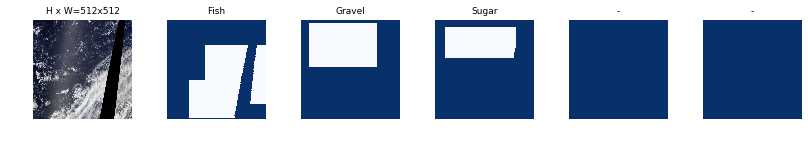

('../../input/understanding_cloud_organization/train_images/7d570e1.jpg', ['Flower', 'Gravel', 'Sugar'])


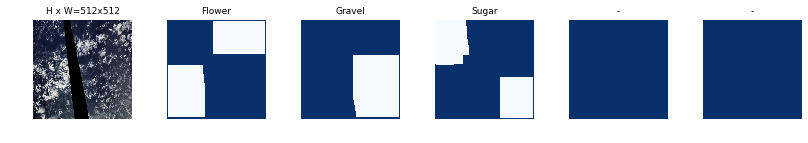

('../../input/understanding_cloud_organization/train_images/79208b2.jpg', ['Gravel', 'Sugar'])


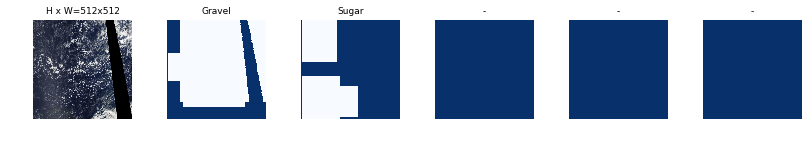

('../../input/understanding_cloud_organization/train_images/4f98f81.jpg', ['Fish', 'Gravel'])


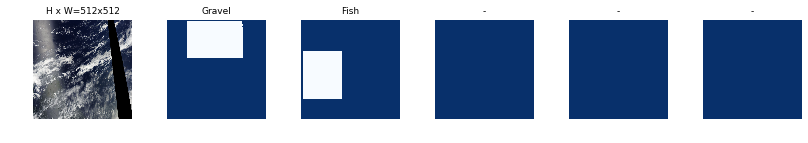

('../../input/understanding_cloud_organization/train_images/bee421c.jpg', ['Flower', 'Sugar'])


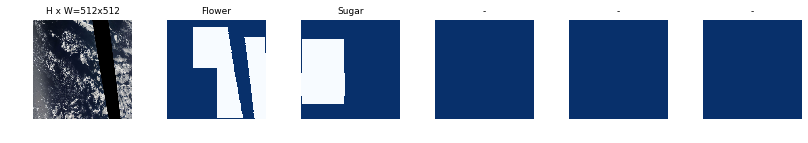

In [15]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(df))
validation_set_size = int((1-training_percentage)*len(df))

train_dataset = CloudDataset(df[:training_set_size])
train_dataset.prepare()

valid_dataset = CloudDataset(df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

for i in range(5):
    image_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_reference(image_id))
    
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

# Start training

Let's hope that this 8 epochs will run within the 9 hours allowed.

In [16]:
LR = 1e-4
EPOCHS = [3,9]

import warnings 
warnings.filterwarnings("ignore")

Augmentation is quite important in our case as it turns out we have very few samples so we flipped the images both vertically and horizontally

In [17]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

We initialize the model with the COCO weights even though they are quite different from the satellite imagery in the dataset provided.

In [18]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [19]:
ls

LICENSE      README.md          mrcnn/            samples/   setup.py
MANIFEST.in  mask_rcnn_coco.h5  requirements.txt  setup.cfg


We will first train the heads before training the entire model.

In [20]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: ../../working/cloud20191122T0435/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

In [21]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 3. LR=0.0001

Checkpoint Path: ../../working/cloud20191122T0435/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

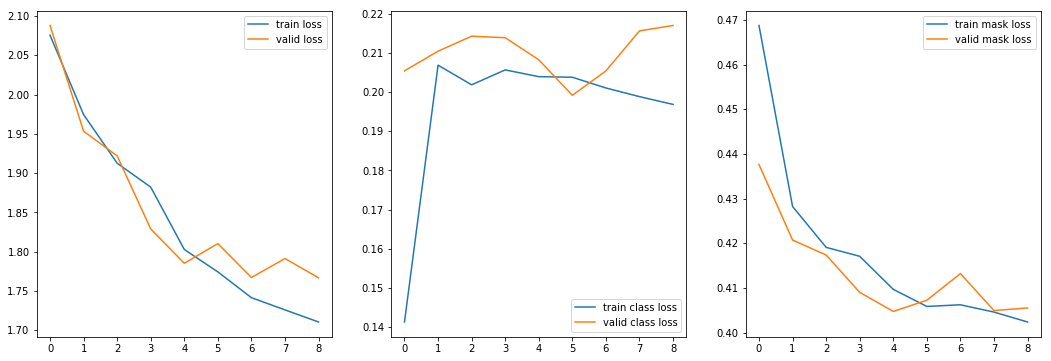

In [22]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [23]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  9
Valid loss:  1.766756889820099
